In [64]:
# import tensorflow as tf
# print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization, TimeDistributed, Bidirectional
# from tensorflow.keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tempfile

In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random


# Parameters
WINDOW_SIZE = 300
STEP_SIZE = 275
TOLERANCE = 0.1
MAX = 20000
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')
LABELS = []
X = []
y = []
well_represented = ['Fridge','Freezer','Washing Machine','Washer Dryer','Tumble Dryer','Dishwasher','Microwave','Toaster','Kettle',
                'Computer','Electric Heater','Hi-Fi','Overhead Fan']


In [ ]:

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def process_file(file_path, label_idx):
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)
    with open(file_path) as f:
        appliance_name = f.readline().strip().split(",")[1]

    if appliance_name not in df.columns:
        return []

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    return [(window, label_idx) for window in extract_windows(signal)]

def load_balanced_dataset(data_dir, well_represented=well_represented):
    global LABELS, X, y

    label_map = {name: i for i, name in enumerate(well_represented)}
    all_windows = {label: [] for label in well_represented}

    # Step 1: Load all data first
    for class_dir in sorted(Path(data_dir).iterdir()):
        if not class_dir.is_dir():
            continue
        class_name = class_dir.name
        if class_name not in well_represented:
            continue
        label_idx = label_map[class_name]
        if class_name not in LABELS:
            LABELS.append(class_name)
        for file in class_dir.glob("*.csv"):
            windows = process_file(file, label_idx)
            all_windows[class_name].extend(windows)

    # Step 2: Select reference class and determine target range
    ref_class = random.choice(well_represented)
    original_ref_count = len(all_windows[ref_class])
    ref_count = min(MAX, original_ref_count)
    print(f"Reference class: {ref_class} (using {ref_count} windows, originally had {original_ref_count})")

    min_required = int(ref_count * (1 - TOLERANCE))
    max_allowed = int(ref_count * (1 + TOLERANCE))
    cap = min(MAX, max_allowed)


    # Step 3: Apply sampling per class
    for label in well_represented:
        class_windows = all_windows[label]
        # needed = random.randint(min_required, cap)
        needed = MAX

        if len(class_windows) >= needed:
            chosen = random.sample(class_windows, needed)
        else:
            repeat_count = (needed // len(class_windows)) + 1
            extended = class_windows * repeat_count
            chosen = extended[:needed]
            chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
                      for (w, lbl) in chosen]

        for window, label_idx in chosen:
            X.append(window)
            y.append(label_idx)

        print(f"{label}: {len(chosen)} samples")

    print("\nClass balance (target ±{:.1f}%, max cap = {}):".format(TOLERANCE * 100, MAX))
    for label in well_represented:
        print(f"{label}: {sum(np.array(y) == label_map[label])} windows")

    X_np = np.array(X)[..., np.newaxis]
    y_np = to_categorical(y, num_classes=len(LABELS))
    return X_np, y_np


X, y = load_balanced_dataset(DATA_DIR)

Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Pr

In [6]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 12105 samples
Dishwasher          : 11943 samples
Electric Heater     : 12059 samples
Freezer             : 11983 samples
Fridge              : 12088 samples
Hi-Fi               : 11970 samples
Kettle              : 11951 samples
Microwave           : 12111 samples
Overhead Fan        : 11923 samples
Toaster             : 11999 samples
Tumble Dryer        : 11957 samples
Washer Dryer        : 11949 samples
Washing Machine     : 11962 samples

Class distribution in VALIDATION set:
Computer            : 5552 samples
Dishwasher          : 5672 samples
Electric Heater     : 5560 samples
Freezer             : 5646 samples
Fridge              : 5490 samples
Hi-Fi               : 5614 samples
Kettle              : 5627 samples
Microwave           : 5495 samples
Overhead Fan        : 5654 samples
Toaster             : 5613 samples
Tumble Dryer        : 5649 samples
Washer Dryer        : 5644 samples
Washing Machine     : 5584 samples

Cla

In [5]:
from keras.layers import Activation, Multiply, Add
from keras.utils import get_custom_objects
from keras.activations import relu

def relu6_div6(x):
    return relu(x, max_value=6) / 6

get_custom_objects().update({'relu6_div6': Activation(relu6_div6)})

def Conv1DGLUBlock(filters, kernel_size):
    def block(x):
        linear = Conv1D(filters, kernel_size, padding='same')(x)
        gate = Conv1D(filters, kernel_size, padding='same')(x)
        gate_out = Activation(relu6_div6)(gate)
        return Multiply()([linear, gate_out])
    return block

def ResidualBlock(filters, kernel_size):
    def block(x):
        out = Conv1DGLUBlock(filters, kernel_size)(x)
        out = Conv1D(filters, kernel_size=1, padding='same')(out)
        if x.shape[-1] != out.shape[-1]:
            x = Conv1D(filters, kernel_size=1, padding='same')(x)  # 1x1 conv to match channels
        return Add()([x, out])
    return block

In [ ]:
# from Conv1D_GLU import Conv1DGLU
# from ResidualBlock import ResidualBlock
from keras.models import Model
from keras.layers import Add

def build_glu_cnn_lstm_model(window_size, num_classes):
    input_layer = Input(shape=(window_size, 1))
    print(f"Input shape: {input_layer.shape}")

    # x = Conv1DGLU(filters=64, kernel_size=5)(input_layer)
    x = ResidualBlock(filters=64, kernel_size=5)(input_layer)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    print(f"Input shape: {x.shape}")
    # input_layer = x  # Save the input for residual connection
    # x2 = Conv1DGLU(filters=128, kernel_size=3)(x)
    x = ResidualBlock(filters=128, kernel_size=3)(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Dropout(0.2)(x)

    # Optional LSTM
    x = LSTM(64)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [114]:
model = build_glu_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Input shape: (None, 300, 1)
Input shape: (None, 150, 64)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 300, 64)   │          0 │ conv1d_107[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_126        │ (None, 300, 64)   │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_126[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 300, 64)   │          0 │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 150, 64)   │          0 │ add_108[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 150, 128)  │          0 │ conv1d_111[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_127        │ (None, 150, 128)  │          0 │ conv1d_110[0][0], │
│ (Multiply)          │                   │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_127[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_109 (Add)       │ (None, 150, 128)  │          0 │ conv1d_113[0][0], │
│                     │                   │            │ conv1d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 75, 128)   │          0 │ add_109[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 75, 128)   │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     49,408 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      8,320 │ lstm_13[0][0]   

 Total params: 138,701 (541.80 KB)

 Trainable params: 138,701 (541.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 80ms/step - accuracy: 0.3831 - loss: 1.6085 - val_accuracy: 0.5754 - val_loss: 1.1115
Epoch 2/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 218s 89ms/step - accuracy: 0.5968 - loss: 1.0672 - val_accuracy: 0.7507 - val_loss: 0.6808
Epoch 3/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 198s 81ms/step - accuracy: 0.7068 - loss: 0.8023 - val_accuracy: 0.7393 - val_loss: 0.6531
Epoch 4/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 82ms/step - accuracy: 0.7467 - loss: 0.6835 - val_accuracy: 0.7954 - val_loss: 0.5785
Epoch 5/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 206s 84ms/step - accuracy: 0.7791 - loss: 0.5828 - val_accuracy: 0.7992 - val_loss: 0.5360
Epoch 6/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 208s 85ms/step - accuracy: 0.7953 - loss: 0.5403 - val_accuracy: 0.8439 - val_loss: 0.4225
Epoch 7/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 81ms/step - accuracy: 0.8292 - loss: 0.4639 - val_accuracy: 0.8550 - val_loss: 0.3860
Epoch 8/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 207s 85ms/step - accuracy: 

In [115]:
from sklearn.metrics import accuracy_score

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
test_accuracy = accuracy_score(y_true, probs)
print("Test Accuracy:", test_accuracy)

975/975 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step
Test Accuracy: 0.8754487179487179


In [116]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          figsize=(12, 10),
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.show()


Confusion matrix, without normalization
[[1783  209    1    0    0    1  291    0    0   41    0   16    1]
 [ 194 1994    0    2    0    0  183    0    0    8    0    4    0]
 [   1    0 2315    5    4   31    2    2    3    7    8    0    3]
 [   0    0    8 2313    0    1    0    0    0   13   27    0    9]
 [   0    0   39   29 2295    0    0    0    6   11   30    0   12]
 [   0    0 1028    3    0 1341    0    0    0    1   43    0    0]
 [  13   13    0    0    0    1 2156    0    0  150    1   88    0]
 [   0    0    0    0    0    0    0 2394    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0 2418    0    0    0    5]
 [  85    8    1    1    1    1  102    0   10 2061    0  118    0]
 [   0    0  580    3    7   33    0    0   54    0 1593    0  124]
 [   1    0    0    0    0    0    1    0   10  113    0 2280    2]
 [   0    0    0    0    0    0    0    0   71   12    0    0 2371]]


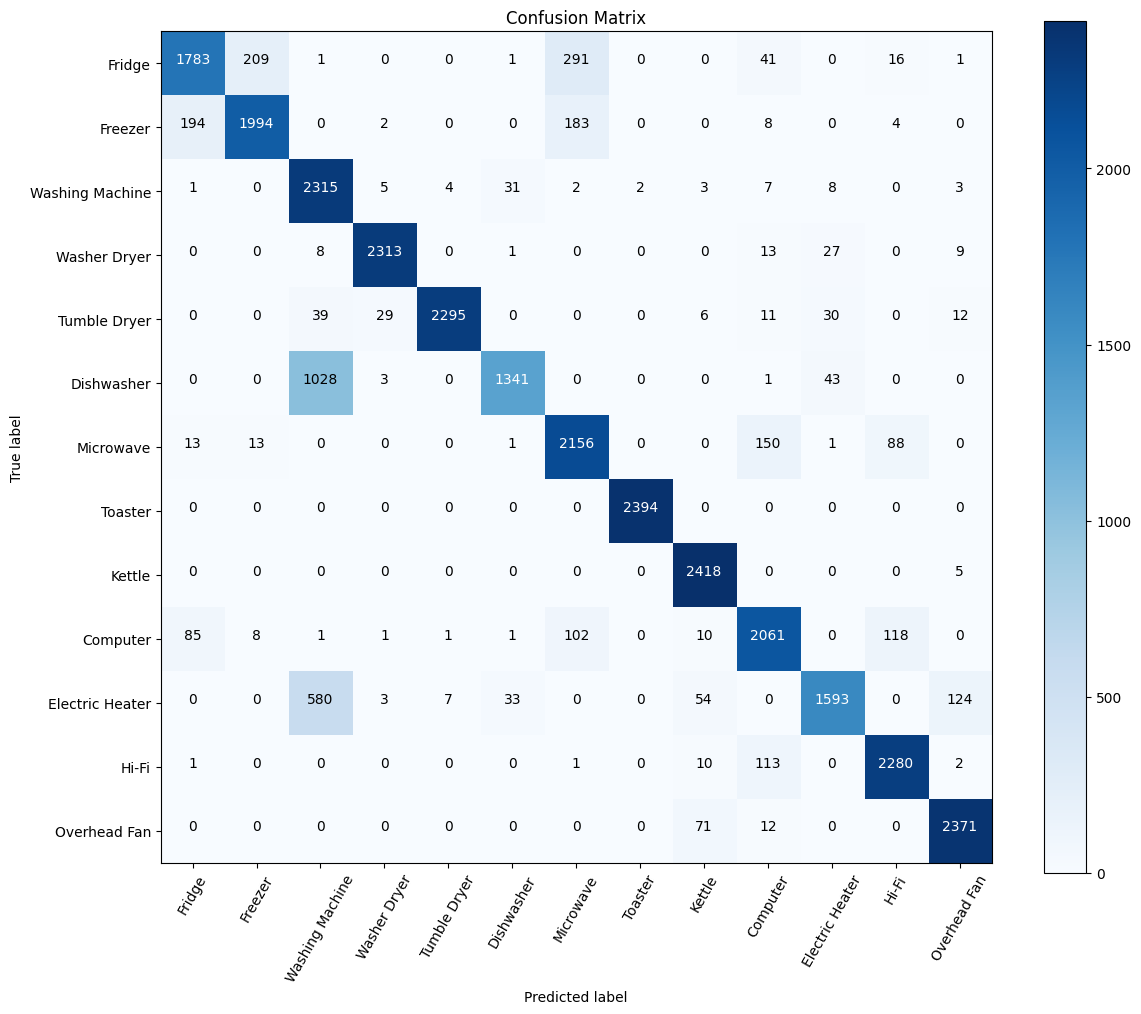

In [117]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)

In [118]:
from sklearn.metrics import classification_report 
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1),target_names=LABELS))

                 precision    recall  f1-score   support

       Computer       0.86      0.76      0.81      2343
     Dishwasher       0.90      0.84      0.87      2385
Electric Heater       0.58      0.97      0.73      2381
        Freezer       0.98      0.98      0.98      2371
         Fridge       0.99      0.95      0.97      2422
          Hi-Fi       0.95      0.56      0.70      2416
         Kettle       0.79      0.89      0.84      2422
      Microwave       1.00      1.00      1.00      2394
   Overhead Fan       0.94      1.00      0.97      2423
        Toaster       0.85      0.86      0.86      2388
   Tumble Dryer       0.94      0.67      0.78      2394
   Washer Dryer       0.91      0.95      0.93      2407
Washing Machine       0.94      0.97      0.95      2454

       accuracy                           0.88     31200
      macro avg       0.89      0.88      0.87     31200
   weighted avg       0.89      0.88      0.87     31200



In [ ]:
# from keras import ops
from keras.models import save_model

save_model(model,'GLU_CNN_LSTM_model.keras')
print('Saved model to: GLU_CNN_LSTM_model.keras')


Saved model to: GLU_CNN_LSTM_model.keras


In [87]:
WINDOW_SIZE = 300
STEP_SIZE = 275

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def prepare_inference_data(aggregate_file_path):
    X_all = []
    column_name = 'Aggregate'  # Change to 'mains' if needed

    for file_path in sorted(Path(aggregate_file_path).glob("*.csv")):
        print(f"Processing: {file_path.name}")
        df = pd.read_csv(file_path)

        # Use 'aggregate' or 'mains' column
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in {file_path.name}")

        signal = df[column_name].fillna(0).values.astype(np.float32)
        windows = extract_windows(signal)
        X_all.extend(windows)

    X_all_np = np.array(X_all)[..., np.newaxis]  # shape: (n_windows, window_size, 1)
    print(f"\nTotal windows extracted: {X_all_np.shape[0]}")
    return X_all_np


In [88]:
path = Path(f"{DATA_DIR}/Aggregate")
X_infer = prepare_inference_data(path)


Processing: Aggregate_House_1.csv_0.csv
Processing: Aggregate_House_1.csv_1.csv
Processing: Aggregate_House_1.csv_10.csv
Processing: Aggregate_House_1.csv_11.csv
Processing: Aggregate_House_1.csv_12.csv
Processing: Aggregate_House_1.csv_13.csv
Processing: Aggregate_House_1.csv_14.csv
Processing: Aggregate_House_1.csv_15.csv
Processing: Aggregate_House_1.csv_16.csv
Processing: Aggregate_House_1.csv_17.csv
Processing: Aggregate_House_1.csv_18.csv
Processing: Aggregate_House_1.csv_19.csv
Processing: Aggregate_House_1.csv_2.csv
Processing: Aggregate_House_1.csv_20.csv
Processing: Aggregate_House_1.csv_21.csv
Processing: Aggregate_House_1.csv_22.csv
Processing: Aggregate_House_1.csv_23.csv
Processing: Aggregate_House_1.csv_24.csv
Processing: Aggregate_House_1.csv_25.csv
Processing: Aggregate_House_1.csv_3.csv
Processing: Aggregate_House_1.csv_4.csv
Processing: Aggregate_House_1.csv_5.csv
Processing: Aggregate_House_1.csv_6.csv
Processing: Aggregate_House_1.csv_7.csv
Processing: Aggregate_Ho

In [ ]:
from keras.models import load_model

loaded_model = load_model('GLU_CNN_LSTM_model.keras')

# predictions = loaded_model.predict(X_infer)
# predicted_classes = np.argmax(predictions, axis=1)

In [194]:
from keras.metrics import BinaryAccuracy, AUC, Recall
from keras.layers import TimeDistributed, Dense, Bidirectional
from keras.optimizers import Adam

# loaded_model.summary()
# for layer in loaded_model.layers[:8]:
#     layer.trainable = False
x = loaded_model.layers[-5].input

# print(f"Shape of second-last layer output: {x.shape}")
# seq2seq = LSTM(64, return_sequences=True, name="lstm_seq")(x)
# seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(seq2seq)
# Compile

seq2seq = ResidualBlock(filters=128, kernel_size=3)(x)
seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

# seq2seq = ResidualBlock(filters=128, kernel_size=3)(seq2seq)
# seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

seq2seq = Bidirectional(LSTM(64, return_sequences=True))(seq2seq)

seq2seq = Dropout(0.2)(seq2seq)
seq2seq = Bidirectional(LSTM(64, return_sequences=True))(seq2seq)
seq2seq = TimeDistributed(Dense(128, activation='relu'))(seq2seq)
seq2seq = Dropout(0.2)(seq2seq)


seq2seq = Dense(6, activation='sigmoid')(seq2seq)
# seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(x)

import tensorflow as tf

# def weighted_binary_crossentropy(pos_weight=4.0):
#     def loss_fn(y_true, y_pred):
#         bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
#         weights = 1.0 + pos_weight * y_true  # weight = 5 if y_true==1, else 1
#         return tf.reduce_mean(bce * weights)
#     return loss_fn

loss = keras.losses.BinaryCrossentropy()
weighted_loss = lambda y_true, y_pred: loss(y_true, y_pred) * (1 + 5*y_true)

import tensorflow as tf
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss

seq2seq_model = Model(inputs=loaded_model.input, outputs=seq2seq)
seq2seq_model.compile(optimizer=Adam(learning_rate=0.01), loss=focal_loss(), metrics=[BinaryAccuracy(name='binary_accuracy'),AUC(name='auc'), Recall(name='recall')])

# # # Summary
seq2seq_model.summary()






Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 300, 64)   │          0 │ conv1d_107[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_126        │ (None, 300, 64)   │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_126[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 300, 64)   │          0 │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 150, 64)   │          0 │ add_108[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 150, 128)  │          0 │ conv1d_111[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_127        │ (None, 150, 128)  │          0 │ conv1d_110[0][0], │
│ (Multiply)          │                   │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_127[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_109 (Add)       │ (None, 150, 128)  │          0 │ conv1d_113[0][0], │
│                     │                   │            │ conv1d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 75, 128)   │          0 │ add_109[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 75, 128)   │     49,280 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 75, 128)   │     49,280 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 75, 128)   │          0 │ conv1d_4[0][0]    │
│ (Activation)        │                   │            │                 

 Total params: 409,286 (1.56 MB)

 Trainable params: 409,286 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
import os
import pandas as pd

temp_appliance_data = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
                  'Television','Hi-Fi']
NUM_SEQUENCES = 5000

def load_appliance_data(root_dir):
    appliance_data = {}

    for appliance in temp_appliance_data:
        appliance_dir = os.path.join(root_dir, appliance)
        if not os.path.isdir(appliance_dir):
            continue

        all_series = []

        for file in os.listdir(appliance_dir):
            print(f"Processing file: {file}")
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(appliance_dir, file))
                # Try to infer the power column
                # power_col = next((col for col in df.columns if appliance in col.lower()), None)
                # if power_col:
                power_col = appliance
                all_series.append(df[power_col].dropna().values)

        if all_series:
            appliance_data[appliance] = all_series
            # if len(all_series) > NUM_SEQUENCES:
            #     appliance_data[appliance] = random.sample(all_series, NUM_SEQUENCES)
    print(f"Loaded data for {len(appliance_data)} appliances.")
    return appliance_data


In [132]:
import numpy as np
import random

def create_synthetic_dataset_from_csvs(
    appliance_data,
    sequence_length=512,
    num_sequences=1000,
    max_agg_power=8000,
    thresholds=None,
    min_appliances_on=3,
    max_appliances_total=6,
    max_attempts_per_seq=10
):
    if thresholds is None:
        thresholds = {
            'Fridge': 10,
            'Freezer': 10,
            'Washing Machine': 20,
            'Washer Dryer': 30,
            'Tumble Dryer': 100,
            'Dishwasher': 30,
            'Microwave': 10,
            'Toaster': 150,
            'Kettle': 50,
            'Computer': 20,
            'Electric Heater': 50,
            'Hi-Fi': 10,
            'Overhead Fan': 20
        }

    appliance_names = list(appliance_data.keys())
    synthetic_X = []
    synthetic_Y = []
    min_on_ratio = 0.4

    for seq_idx in range(num_sequences):
        print(f"Generating sequence {seq_idx + 1}/{num_sequences}")

        for attempt in range(max_attempts_per_seq):
            agg_seq = np.zeros(sequence_length)
            appliance_power_matrix = np.zeros((sequence_length, len(appliance_names)))

            selected_appliances = random.sample(appliance_names, k=random.randint(min_appliances_on, max_appliances_total))
            on_appliance_count = 0

            for appliance in selected_appliances:
                idx = appliance_names.index(appliance)
                csv_list = appliance_data[appliance]
                if not csv_list:
                    continue

                threshold = thresholds.get(appliance, 50)
                found_on_segment = False

                for _ in range(5):
                    series = random.choice(csv_list)
                    if len(series) < sequence_length:
                        series = np.pad(series, (0, sequence_length - len(series)))
                    else:
                        start = random.randint(0, len(series) - sequence_length)
                        series = series[start:start + sequence_length]

                    if (series > threshold).sum() >= sequence_length * min_on_ratio:
                        found_on_segment = True
                        break

                if not found_on_segment:
                    continue

                temp_agg = agg_seq + series
                if np.max(temp_agg) <= max_agg_power:
                    agg_seq = temp_agg
                    appliance_power_matrix[:, idx] = series
                    on_appliance_count += 1

            # Only accept sequences with required ON appliances
            if on_appliance_count >= min_appliances_on:
                break

        # Downsample ON/OFF labels
        label_vector = []
        for i, appliance in enumerate(appliance_names):
            threshold = thresholds.get(appliance, 50)
            downsampled = appliance_power_matrix[:, i].reshape(-1, 4).mean(axis=1)
            on_off = (downsampled > threshold).astype(int)
            label_vector.append(on_off)

        label_matrix = np.stack(label_vector, axis=-1)
        synthetic_X.append(agg_seq.reshape(sequence_length, 1))
        synthetic_Y.append(label_matrix)

    X = np.array(synthetic_X)
    y = np.array(synthetic_Y)
    return X, y, appliance_names


In [162]:
appliance_data = load_appliance_data(DATA_DIR)


Processing file: Fridge_House_1.csv_0.csv
Processing file: Fridge_House_1.csv_10.csv
Processing file: Fridge_House_1.csv_100.csv
Processing file: Fridge_House_1.csv_101.csv
Processing file: Fridge_House_1.csv_102.csv
Processing file: Fridge_House_1.csv_103.csv
Processing file: Fridge_House_1.csv_104.csv
Processing file: Fridge_House_1.csv_105.csv
Processing file: Fridge_House_1.csv_106.csv
Processing file: Fridge_House_1.csv_107.csv
Processing file: Fridge_House_1.csv_108.csv
Processing file: Fridge_House_1.csv_109.csv
Processing file: Fridge_House_1.csv_110.csv
Processing file: Fridge_House_1.csv_111.csv
Processing file: Fridge_House_1.csv_112.csv
Processing file: Fridge_House_1.csv_113.csv
Processing file: Fridge_House_1.csv_114.csv
Processing file: Fridge_House_1.csv_115.csv
Processing file: Fridge_House_1.csv_116.csv
Processing file: Fridge_House_1.csv_117.csv
Processing file: Fridge_House_1.csv_118.csv
Processing file: Fridge_House_1.csv_119.csv
Processing file: Fridge_House_1.csv

In [133]:
# print(appliance_data)  # Check loaded appliances
# Create synthetic dataset
X, Y, Labels = create_synthetic_dataset_from_csvs(appliance_data, sequence_length=300, num_sequences=30000)

print("X shape (aggregated):", X.shape)  # (5000, 300, 1)
print("Y shape (labels):", Y.shape)      # (5000, 300, num_appliances)
print("Appliance order:", Labels)

print("Example aggregated input (first sequence):", X[0])  # Show first 10 values
print("Example aggregated input (first sequence):", Y[0])  # Show first 10 values

Generating sequence 1/30000
Generating sequence 2/30000
Generating sequence 3/30000
Generating sequence 4/30000
Generating sequence 5/30000
Generating sequence 6/30000
Generating sequence 7/30000
Generating sequence 8/30000
Generating sequence 9/30000
Generating sequence 10/30000
Generating sequence 11/30000
Generating sequence 12/30000
Generating sequence 13/30000
Generating sequence 14/30000
Generating sequence 15/30000
Generating sequence 16/30000
Generating sequence 17/30000
Generating sequence 18/30000
Generating sequence 19/30000
Generating sequence 20/30000
Generating sequence 21/30000
Generating sequence 22/30000
Generating sequence 23/30000
Generating sequence 24/30000
Generating sequence 25/30000
Generating sequence 26/30000
Generating sequence 27/30000
Generating sequence 28/30000
Generating sequence 29/30000
Generating sequence 30/30000
Generating sequence 31/30000
Generating sequence 32/30000
Generating sequence 33/30000
Generating sequence 34/30000
Generating sequence 35/

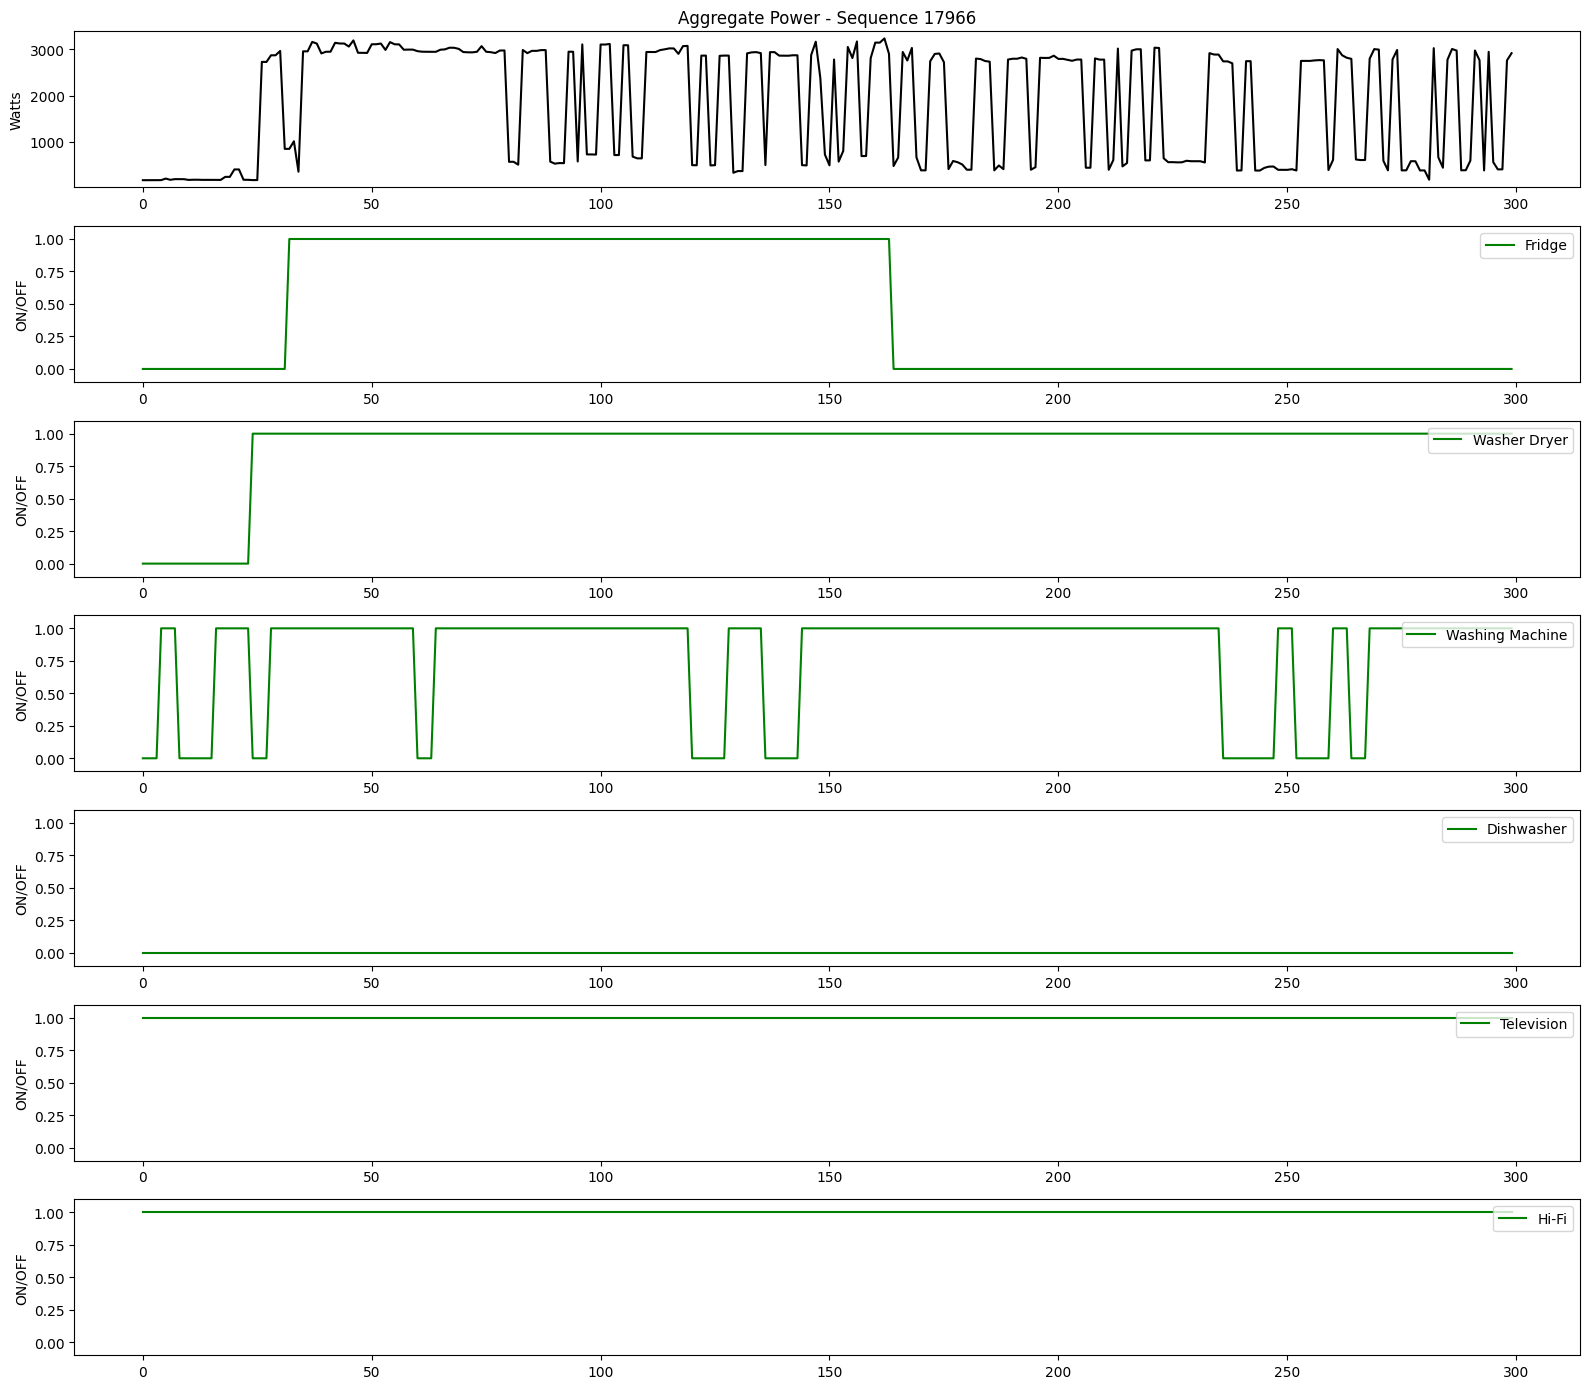

In [134]:
import matplotlib.pyplot as plt
import numpy as np

def plot_synthetic_examples(X, Y, appliance_names, num_examples=3):
    """
    Plot aggregate input signal and ON/OFF labels per appliance for a few sequences.

    Args:
        X (np.array): Shape (num_samples, sequence_length, 1)
        Y (np.array): Shape (num_samples, sequence_length_downsampled, num_appliances)
        appliance_names (List[str]): List of appliance names
        num_examples (int): Number of random examples to show
    """
    num_appliances = len(appliance_names)
    seq_len = X.shape[1]
    down_len = Y.shape[1]
    down_factor = seq_len // down_len

    indices = np.random.choice(len(X), size=num_examples, replace=False)

    for idx in indices:
        plt.figure(figsize=(16, 2 + 2 * num_appliances))
        
        # Plot aggregate power signal
        plt.subplot(num_appliances + 1, 1, 1)
        plt.plot(X[idx].squeeze(), color='black')
        plt.title(f'Aggregate Power - Sequence {idx}')
        plt.ylabel("Watts")

        # Plot each appliance ON/OFF label
        for i in range(num_appliances):
            plt.subplot(num_appliances + 1, 1, i + 2)
            plt.plot(np.repeat(Y[idx][:, i], down_factor), label=appliance_names[i], color='green')
            plt.ylabel("ON/OFF")
            plt.ylim(-0.1, 1.1)
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

appliance_names = [
    'Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
    'Television','Hi-Fi'
]

plot_synthetic_examples(X, Y, appliance_names, num_examples=1)



In [59]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # What to track
    factor=0.5,           # Reduce LR by this factor
    patience=3,           # Wait this many epochs with no improvement
    min_lr=1e-6,          # Minimum LR to avoid going too low
    verbose=1             # Print updates
)


In [135]:

# Create a DataFrame
def imbalance_calc (y, dataset):
    y_flat = y.reshape(-1, y.shape[-1])
    on_percentage = 100 * np.mean(y_flat, axis=0)
    off_percentage = 100 - on_percentage
    on_off_df = pd.DataFrame({
        f'Appliance in {dataset}': [f'{temp_appliance_data[i]}' for i in range(y.shape[-1])],
        'ON (%)': on_percentage,
        'OFF (%)': off_percentage
    })
    print(on_off_df)

imbalance_calc(Y,'Dataset')


  Appliance in Dataset     ON (%)    OFF (%)
0               Fridge  55.187200  44.812800
1         Washer Dryer  65.106356  34.893644
2      Washing Machine  64.275600  35.724400
3           Dishwasher  60.830667  39.169333
4           Television  65.908978  34.091022
5                Hi-Fi  69.132978  30.867022


In [136]:
print(f"Generated {len(X)} sequences with shape {X.shape} and labels shape {Y.shape}")
history = seq2seq_model.fit(X, Y, epochs=10, batch_size=64, validation_split=0.1)

Generated 30000 sequences with shape (30000, 300, 1) and labels shape (30000, 75, 6)
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 98s 232ms/step - auc: 0.6236 - binary_accuracy: 0.6589 - loss: 0.0365 - recall: 0.9496 - val_auc: 0.6533 - val_binary_accuracy: 0.6725 - val_loss: 0.0355 - val_recall: 0.9277
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 110s 260ms/step - auc: 0.6352 - binary_accuracy: 0.6639 - loss: 0.0360 - recall: 0.9331 - val_auc: 0.6551 - val_binary_accuracy: 0.6761 - val_loss: 0.0350 - val_recall: 0.9185
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 113s 267ms/step - auc: 0.6457 - binary_accuracy: 0.6728 - loss: 0.0353 - recall: 0.9297 - val_auc: 0.6604 - val_binary_accuracy: 0.6761 - val_loss: 0.0348 - val_recall: 0.8837
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 112s 266ms/step - auc: 0.6520 - binary_accuracy: 0.6748 - loss: 0.0350 - recall: 0.9253 - val_auc: 0.6699 - val_binary_accuracy: 0.6836 - val_loss: 0.0339 - val_recall: 0.9239
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 115s 271ms/s

In [137]:
# Predict on test data
print(X.shape)
train_preds = seq2seq_model.predict(X.squeeze(axis=-1), verbose=1)

# Threshold predictions to 0/1 (optional: use different threshold)
preds_train_binary = (train_preds > 0.5).astype(int)


(30000, 300, 1)
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step


In [138]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_appliances = preds_train_binary.shape[2]
per_appliance_acc_train = []

for i in range(num_appliances):
    y_true = Y[:, :, i].flatten()
    y_pred = preds_train_binary[:, :, i].flatten()
    
    acc = accuracy_score(y_true, y_pred)
    per_appliance_acc_train.append(acc)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"{appliance_names[i]} - Train Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")





Fridge - Train Acc: 0.6791 | Prec: 0.6824 | Rec: 0.7830 | F1: 0.7292
Washer Dryer - Train Acc: 0.7349 | Prec: 0.7381 | Rec: 0.9189 | F1: 0.8186
Washing Machine - Train Acc: 0.7159 | Prec: 0.7644 | Rec: 0.8065 | F1: 0.7849
Dishwasher - Train Acc: 0.6233 | Prec: 0.6263 | Rec: 0.9439 | F1: 0.7530
Television - Train Acc: 0.6592 | Prec: 0.6592 | Rec: 0.9999 | F1: 0.7946
Hi-Fi - Train Acc: 0.6913 | Prec: 0.6914 | Rec: 0.9998 | F1: 0.8175


In [139]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gt_vs_prediction_lines(agg_signal, true_labels, pred_labels, appliance_names, sample_idx=0):
    """
    Plots aggregate signal and ON segments as dashed lines (--) for each appliance.
    Separate plots for ground truth and predictions.

    Parameters:
    - agg_signal: (sequence_length,) array
    - true_labels: (sequence_length // 4, num_appliances)
    - pred_labels: same shape
    - appliance_names: list of appliance names
    - sample_idx: index for labeling
    """
    num_appliances = true_labels.shape[1]
    sequence_length = len(agg_signal)
    downsample_factor = sequence_length // true_labels.shape[0]
    time_axis = np.arange(sequence_length)

    fig, axs = plt.subplots(3, 1, figsize=(16, 8), sharex=True,
                            gridspec_kw={'height_ratios': [1.5, 1, 1]})

    # Plot aggregate power
    axs[0].plot(time_axis, agg_signal, color='black', linewidth=1.5)
    axs[0].set_title("Aggregate Power")
    axs[0].set_ylabel("Power (W)")
    axs[0].grid(True)

    # Plot Ground Truth
    for i in range(num_appliances):
        y_pos = i  # vertical position for the appliance line
        for t in range(true_labels.shape[0]):
            if true_labels[t, i] == 1:
                start = t * downsample_factor
                end = (t + 1) * downsample_factor
                axs[1].hlines(y=y_pos, xmin=start, xmax=end, colors='green', linestyles='--', linewidth=2)

    axs[1].set_yticks(range(num_appliances))
    axs[1].set_yticklabels(appliance_names)
    axs[1].set_title("Ground Truth Appliance Activations")
    axs[1].grid(True)

    # Plot Predictions
    for i in range(num_appliances):
        y_pos = i
        for t in range(pred_labels.shape[0]):
            if pred_labels[t, i] == 1:
                start = t * downsample_factor
                end = (t + 1) * downsample_factor
                axs[2].hlines(y=y_pos, xmin=start, xmax=end, colors='blue', linestyles='--', linewidth=2)

    axs[2].set_yticks(range(num_appliances))
    axs[2].set_yticklabels(appliance_names)
    axs[2].set_title("Predicted Appliance Activations")
    axs[2].set_xlabel("Time Steps")
    axs[2].grid(True)

    plt.tight_layout()
    plt.suptitle(f"Sample {sample_idx}: Ground Truth vs Prediction", fontsize=16, y=1.02)
    plt.show()


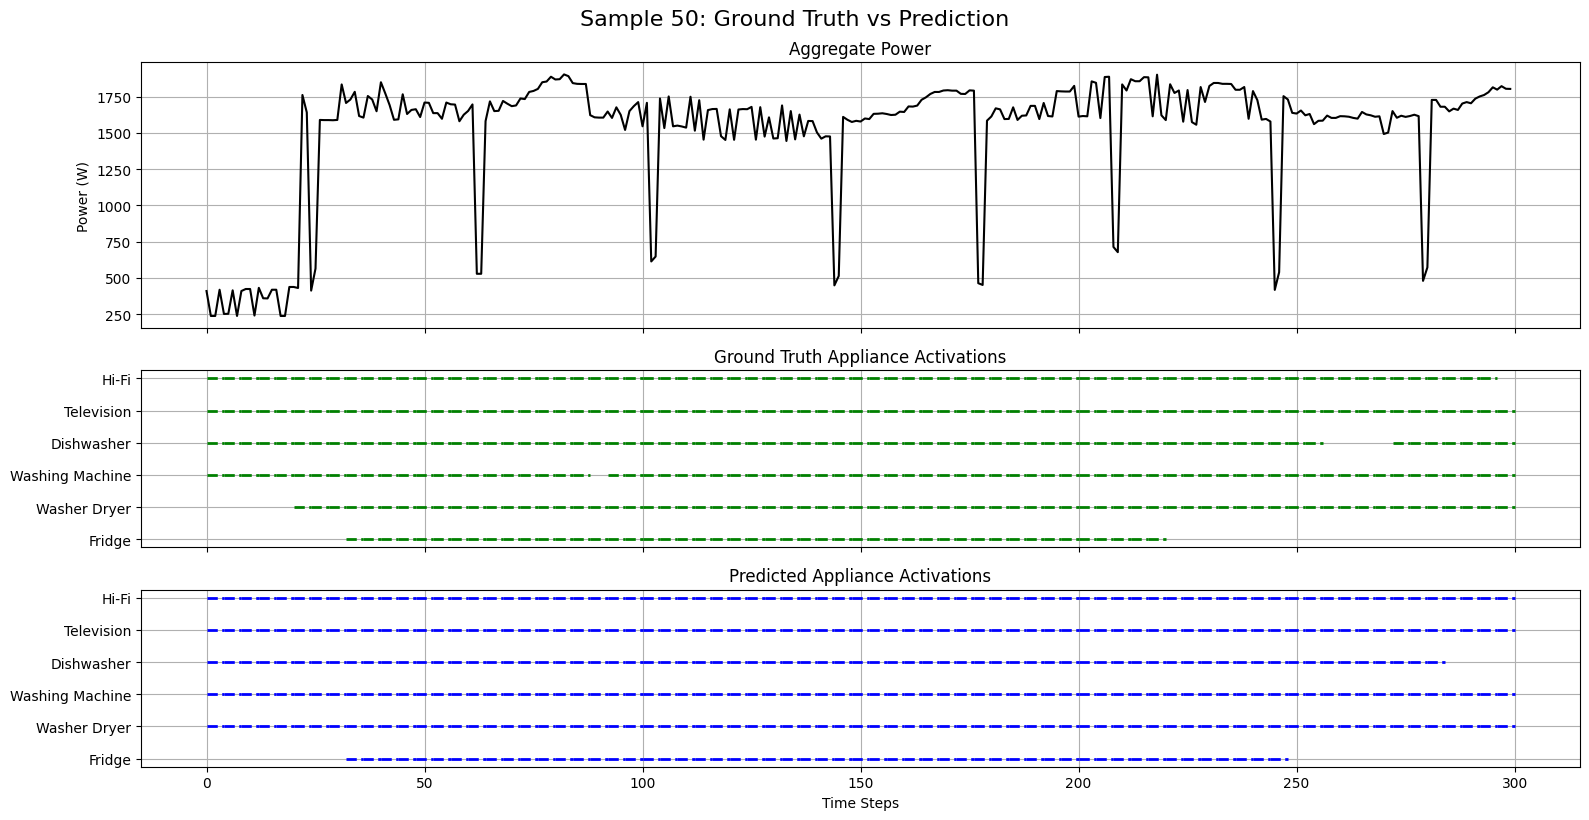

In [147]:
sample_idx = 50
agg_signal = X[sample_idx].squeeze()
true_labels = Y[sample_idx]
pred_labels = preds_train_binary[sample_idx]  # shape: (128, num_appliances)

plot_gt_vs_prediction_lines(agg_signal, true_labels, pred_labels, appliance_names, sample_idx)


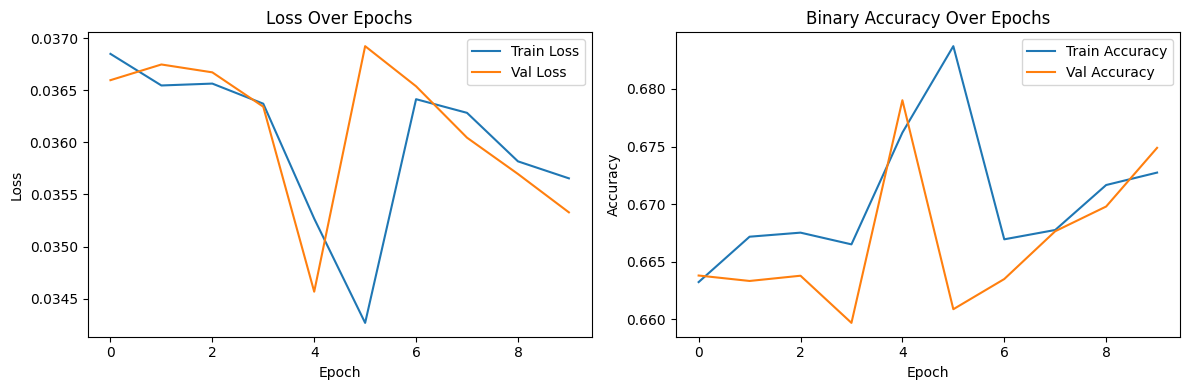

In [104]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PARAMETERS
WINDOW_SIZE = 300
STRIDE = 150
TARGET_COLUMNS = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
                  'Television', 'Hi-Fi', 'Kettle', 'Microwave', 'Electric Heater']
AGG_COLUMN = 'Aggregate'
UNIX_COLUMN = 'Unix'
NUM_SAMPLES = 10000

# Load CSV
df = pd.read_csv(f'{DATA_DIR}/House_9.csv')

# Drop unnecessary columns (keep only aggregate + target appliances)
df = df[[AGG_COLUMN, *TARGET_COLUMNS, UNIX_COLUMN]]



# Normalize (fit on full dataset or just training)
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Function to create windowed sequences
def create_sequences(data, target_appliances= TARGET_COLUMNS, appliances_to_remove = [],window_size=300, stride=150):
    count = 0
    X = []
    y = []

    # Get column indices
    agg_idx = data.columns.get_loc(AGG_COLUMN)

    remove_idxs = [data.columns.get_loc(col) for col in appliances_to_remove]
    
    new_data = data.drop(columns=appliances_to_remove, errors='ignore')
    target_appliances = [col for col in target_appliances if col not in appliances_to_remove]
    target_idxs = [new_data.columns.get_loc(col) for col in target_appliances]
    for i in range(0, len(new_data) - window_size, stride):
        if count >= NUM_SAMPLES:
            break

        window = new_data.iloc[i:i + window_size].fillna(0).values.astype(np.float32)
        for_data_removal = data.iloc[i:i + window_size].fillna(0).values.astype(np.float32)

        # Normalize the window
        # max_val = np.max(np.abs(window))
        # if max_val > 0:
        #     window = window / max_val

        # Aggregate signal (1D input)
        agg_window = np.copy(window[:, agg_idx])
        print(window.shape)
        print(agg_window.shape)
        for idx in remove_idxs:

            agg_window -= for_data_removal[:, idx]

        # Aggregate signal (1D input)

        X.append(agg_window)  # shape: (300, 1)

        # Extract target appliance usage
        target_data = window[:, target_idxs]  # shape: (300, 9)

        # Downsample to 75 by averaging every 4 rows
        chunks = np.split(target_data[:300], 75)  # 300/4 = 75
        # mean_chunks = np.array([chunk.mean(axis=0) for chunk in chunks])  # shape: (75, 9)
        combined_chunks = np.array([
        chunk.min(axis=0)  # min across 4 samples → shape: (9,)
        for chunk in chunks
        ])  # shape: (75, 9)
        # max_chunks = np.array([chunk.max(axis=0) for chunk in chunks])  # preserves peak
        # presence_chunks = (chunks > 10).any(axis=0).astype(float)
        y.append(combined_chunks)

        count += 1
        print(count)

    y = np.array(y)

# Apply threshold after conversion to NumPy array
    y = (y > 10).astype(int)

    return np.array(X), np.array(y)

X_test, y_test = create_sequences(df,appliances_to_remove=['Kettle','Microwave','Electric Heater'], window_size=WINDOW_SIZE, stride=STRIDE)

# Use last time step label or mean if desired
# y = y[:, -1, :]  # Optional

# Print shapes
print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

(300, 8)
(300,)
1
(300, 8)
(300,)
2
(300, 8)
(300,)
3
(300, 8)
(300,)
4
(300, 8)
(300,)
5
(300, 8)
(300,)
6
(300, 8)
(300,)
7
(300, 8)
(300,)
8
(300, 8)
(300,)
9
(300, 8)
(300,)
10
(300, 8)
(300,)
11
(300, 8)
(300,)
12
(300, 8)
(300,)
13
(300, 8)
(300,)
14
(300, 8)
(300,)
15
(300, 8)
(300,)
16
(300, 8)
(300,)
17
(300, 8)
(300,)
18
(300, 8)
(300,)
19
(300, 8)
(300,)
20
(300, 8)
(300,)
21
(300, 8)
(300,)
22
(300, 8)
(300,)
23
(300, 8)
(300,)
24
(300, 8)
(300,)
25
(300, 8)
(300,)
26
(300, 8)
(300,)
27
(300, 8)
(300,)
28
(300, 8)
(300,)
29
(300, 8)
(300,)
30
(300, 8)
(300,)
31
(300, 8)
(300,)
32
(300, 8)
(300,)
33
(300, 8)
(300,)
34
(300, 8)
(300,)
35
(300, 8)
(300,)
36
(300, 8)
(300,)
37
(300, 8)
(300,)
38
(300, 8)
(300,)
39
(300, 8)
(300,)
40
(300, 8)
(300,)
41
(300, 8)
(300,)
42
(300, 8)
(300,)
43
(300, 8)
(300,)
44
(300, 8)
(300,)
45
(300, 8)
(300,)
46
(300, 8)
(300,)
47
(300, 8)
(300,)
48
(300, 8)
(300,)
49
(300, 8)
(300,)
50
(300, 8)
(300,)
51
(300, 8)
(300,)
52
(300, 8)
(300,)
53
(3

In [100]:
# Predict on test data
preds = seq2seq_model.predict(X_test)

# Threshold predictions to 0/1 (optional: use different threshold)
preds_binary = (preds > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step


In [101]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# y_test and preds_binary shape: (num_samples, num_appliances)

# Option 1: Overall accuracy (flatten all)
overall_accuracy = accuracy_score(y_test.flatten(), preds_binary.flatten())
print(f'Overall test accuracy: {overall_accuracy:.4f}')

# Option 2: Per-appliance accuracy
num_appliances = min(y_test.shape[1], len(TARGET_COLUMNS))

per_appliance_acc = []
for i in range(num_appliances):
    acc = accuracy_score(y_test[:, i], preds_binary[:, i])
    per_appliance_acc.append(acc)
    print(f'Accuracy for appliance {TARGET_COLUMNS[i]}: {acc:.4f}')



Overall test accuracy: 0.3075
Accuracy for appliance Fridge: 0.0024
Accuracy for appliance Washer Dryer: 0.0035
Accuracy for appliance Washing Machine: 0.0039
Accuracy for appliance Dishwasher: 0.0042
Accuracy for appliance Television: 0.0036
Accuracy for appliance Hi-Fi: 0.0031
Accuracy for appliance Kettle: 0.0033
Accuracy for appliance Microwave: 0.0024
Accuracy for appliance Electric Heater: 0.0019


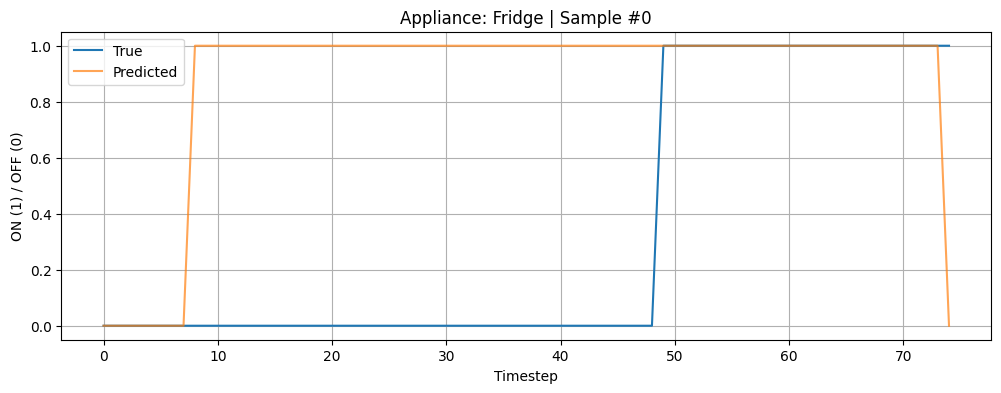

In [106]:
import matplotlib.pyplot as plt

def plot_sample_prediction(X, y_true, y_pred, appliance_idx, appliance_name, sample_idx=0):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[sample_idx, :, appliance_idx], label='True')
    plt.plot(y_pred[sample_idx, :, appliance_idx], label='Predicted', alpha=0.7)
    plt.title(f'Appliance: {appliance_name} | Sample #{sample_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('ON (1) / OFF (0)')
    plt.legend()
    plt.grid(True)
    plt.show()

appliance_idx = appliance_names.index("Fridge")
plot_sample_prediction(X_test, y_test, preds_binary, appliance_idx, "Fridge")



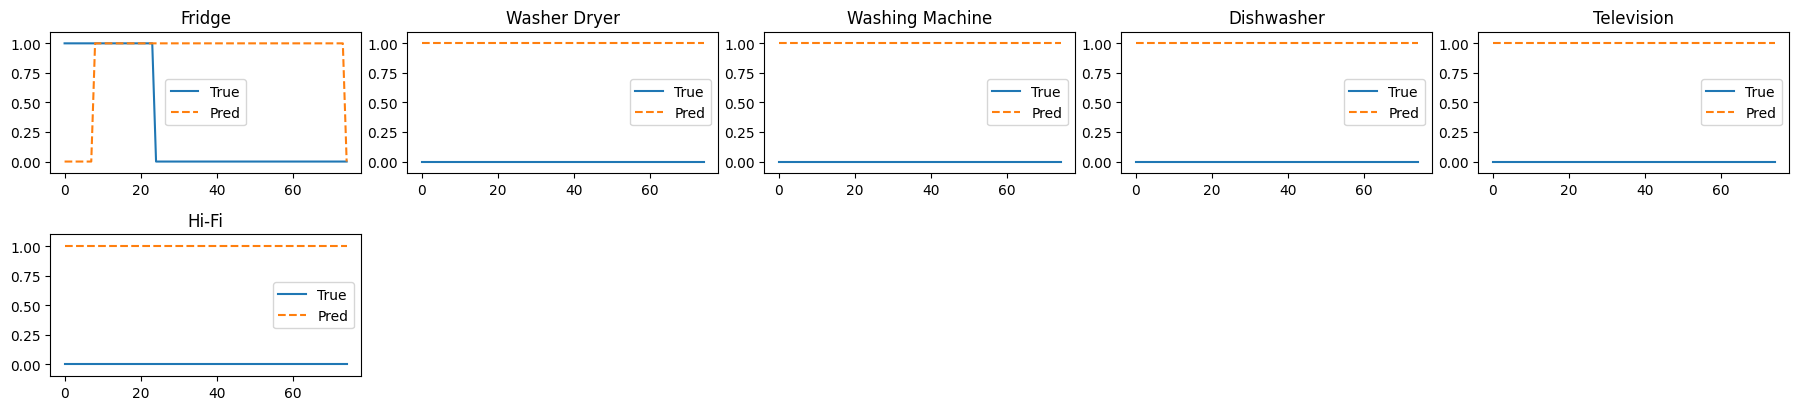

In [102]:

appliance_names = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
                   'Television', 'Hi-Fi']
idx = 40
plt.figure(figsize=(18, 6))
for i in range(len(appliance_names)):
    plt.subplot(3, 5, i+1)
    plt.plot(y_test[idx, :, i], label='True', linestyle='-')
    plt.plot(preds_binary[idx, :, i], label='Pred', linestyle='--')
    plt.title(appliance_names[i])
    plt.ylim(-0.1, 1.1)
    plt.legend()

plt.tight_layout()
plt.show()
